In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
import dicom
import scipy.ndimage
import matplotlib.pyplot as plt
import time
import traceback
import tensorflow as tf
import numpy as np
import scipy.ndimage

from multiprocessing.dummy import Pool as ThreadPool 
from tqdm import tqdm
from skimage import measure, morphology
from skimage.draw import polygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tempfile import TemporaryFile

# Get a list of patient folders in the data folder.
INPUT_FOLDER = 'example_dcm/'
patients = os.walk('./example_dcm').next()[1]
patients.sort()

test_patients = os.walk('./provisional_dcm_no_gt').next()[1]
test_patients.sort()

In [2]:
IMG_SIZE_PX = 50
SLICE_COUNT = 20
NUM_EPOCHS = 1



n_classes = 6

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

In [3]:
def get_bounding_cube(cancer, resize_factor):
    a = np.where(cancer != 0)
    coords = np.min(a[0]), np.max(a[0]), np.min(a[1]), np.max(a[1]), np.min(a[2]), np.max(a[2])
    box = [coords[0] * resize_factor[0], coords[2] * resize_factor[1], coords[4] * resize_factor[2], (coords[1] - coords[0]) * resize_factor[0], (coords[3] - coords[2]) * resize_factor[1], (coords[5] - coords[4]) * resize_factor[2]]
    return box

In [4]:
# Load the CT and RT documents for a patient.
def load_scan(path):
    def listdir_nohidden(path):
        for f in os.listdir(path):
            if not f.startswith('.'):
                yield f
    slice_rt = [dicom.read_file(path + "/RTst/" + s) for s in listdir_nohidden(path + "/RTst")]
    slice_ct = [dicom.read_file(path + "/CT/" + s) for s in listdir_nohidden(path + "/CT")]
    slice_ct.sort(key = lambda x: int(x.ImagePositionPatient[2]))    
    return slice_ct, slice_rt

In [5]:
def get_image_patient(patient):
    if os.path.exists(INPUT_FOLDER + patient + "/50x50x20.npy"):
        if os.path.exists(INPUT_FOLDER + patient + "/50x50x20_cancer.npy"):
            resized_image = np.load(INPUT_FOLDER + patient + "/50x50x20.npy");
            cancer_cube = np.load(INPUT_FOLDER + patient + "/50x50x20_cancer.npy");
            return resized_image, cancer_cube / 50;
        
    image = np.load(INPUT_FOLDER + patient + "/image.npy");
    cancer = np.load(INPUT_FOLDER + patient + "/truthV1.npy");
    resize_factor = [float(IMG_SIZE_PX) / image.shape[0], float(IMG_SIZE_PX) / image.shape[1], float(SLICE_COUNT) / image.shape[2]]
    resized_image = scipy.ndimage.interpolation.zoom(image, resize_factor, mode='nearest');
    cancer_cube = get_bounding_cube(cancer, 1 / image.shape);
    np.save(INPUT_FOLDER + patient + "/50x50x20.npy", resized_image);
    np.save(INPUT_FOLDER + patient + "/50x50x20_cancer.npy", cancer_cube);
    
    # Uncomment to show image of patient CT somewhere in the middle
    # plt.imshow(resized_image.transpose()[30])
    # plt.show()
            
    return resized_image, cancer_cube 

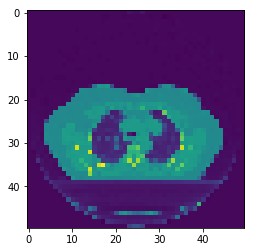

In [6]:
a,b = get_image_patient(patients[0])
plt.imshow(a.transpose()[10])
plt.show()
            

In [7]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')
def fc(x, weight, bias):
    shape = x.get_shape().as_list()
    dim = 1
    for d in shape[1:]:
        if d is not None:
            dim *= d
    x = tf.reshape(x, [-1, dim])
    return tf.matmul(x, weight) + bias

In [8]:
def conv_2(x):
               # 3 x 3 x 3 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3, 3, 3, 1, 32])),
               # 3 x 3 x 3 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3, 3, 3, 32, 64])),
               # 52 because 50 plus zero padding on each border
               'W_fc':tf.Variable(tf.random_normal([(IMG_SIZE_PX + 2) * (IMG_SIZE_PX + 2) * SLICE_COUNT, 1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = { 'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes], 0, 0.1))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, (IMG_SIZE_PX + 2) * (IMG_SIZE_PX + 2) * SLICE_COUNT])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc']) + biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out']) + biases['out']

    return output

In [9]:
def vgg_16(x):
    weights = {'conv1_1':tf.Variable(tf.random_normal([3, 3, 3, 1, 64])),
               'conv1_2':tf.Variable(tf.random_normal([3, 3, 3, 64, 64])),
               'conv2_1':tf.Variable(tf.random_normal([3, 3, 3, 64, 128])),
               'conv2_2':tf.Variable(tf.random_normal([3, 3, 3, 128, 128])),
               'conv3_1':tf.Variable(tf.random_normal([3, 3, 3, 128, 256])),
               'conv3_2':tf.Variable(tf.random_normal([3, 3, 3, 256, 256])),
               'conv3_3':tf.Variable(tf.random_normal([3, 3, 3, 256, 256])),
               'conv4_1':tf.Variable(tf.random_normal([3, 3, 3, 256, 512])),
               'conv4_2':tf.Variable(tf.random_normal([3, 3, 3, 512, 512])),
               'conv4_3':tf.Variable(tf.random_normal([3, 3, 3, 512, 512])),
               'conv5_1':tf.Variable(tf.random_normal([3, 3, 3, 512, 512])),
               'conv5_2':tf.Variable(tf.random_normal([3, 3, 3, 512, 512])),
               'conv5_3':tf.Variable(tf.random_normal([3, 3, 3, 512, 512])),
               'fc6':tf.Variable(tf.random_normal([2048, 2048])),
               'fc7':tf.Variable(tf.random_normal([2048, 1024])),               
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = { 'b_conv1_1':tf.Variable(tf.random_normal([64])),
               'b_conv1_2':tf.Variable(tf.random_normal([64])),
               'b_conv2_1':tf.Variable(tf.random_normal([64])),
               'b_conv2_2':tf.Variable(tf.random_normal([128])),
               'b_conv3_1':tf.Variable(tf.random_normal([256])),
               'b_conv3_2':tf.Variable(tf.random_normal([256])),
               'b_conv3_3':tf.Variable(tf.random_normal([256])),
               'b_conv4_1':tf.Variable(tf.random_normal([512])),
               'b_conv4_2':tf.Variable(tf.random_normal([512])),
               'b_conv4_3':tf.Variable(tf.random_normal([512])),
               'b_conv5_1':tf.Variable(tf.random_normal([512])),
               'b_conv5_2':tf.Variable(tf.random_normal([512])),
               'b_conv5_3':tf.Variable(tf.random_normal([512])),
               'b_fc6':tf.Variable(tf.random_normal([2048])),
               'b_fc7':tf.Variable(tf.random_normal([1024])),               
               'out':tf.Variable(tf.random_normal([n_classes], 0, 0.1))}
    
     #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])
    
    conv1_1 = tf.nn.relu(conv3d(x, weights['conv1_1']) + biases['b_conv1_1'])
    conv1_2 = tf.nn.relu(conv3d(conv1_1, weights['conv1_2']) + biases['b_conv1_2'])
    pool1 = maxpool3d(conv1_2)
    
    conv2_1 = tf.nn.relu(conv3d(pool1, weights['conv2_1']) + biases['b_conv2_1'])
    conv2_2 = tf.nn.relu(conv3d(conv2_1, weights['conv2_2']) + biases['b_conv2_2'])
    pool2 = maxpool3d(conv2_1)
    
    conv3_1 = tf.nn.relu(conv3d(pool2, weights['conv3_1']) + biases['b_conv3_1'])
    conv3_2 = tf.nn.relu(conv3d(conv3_1, weights['conv3_2']) + biases['b_conv3_2'])
    conv3_3 = tf.nn.relu(conv3d(conv3_2, weights['conv3_3']) + biases['b_conv3_3'])
    pool3 = maxpool3d(conv3_3)
    
    conv4_1 = tf.nn.relu(conv3d(pool3, weights['conv4_1']) + biases['b_conv4_1'])
    conv4_2 = tf.nn.relu(conv3d(conv4_1, weights['conv4_2']) + biases['b_conv4_2'])
    conv4_3 = tf.nn.relu(conv3d(conv4_2, weights['conv4_3']) + biases['b_conv4_3'])
    pool4 = maxpool3d(conv4_3)
    
    conv5_1 = tf.nn.relu(conv3d(pool4, weights['conv5_1']) + biases['b_conv5_1'])
    conv5_2 = tf.nn.relu(conv3d(conv5_1, weights['conv5_2']) + biases['b_conv5_2'])
    conv5_3 = tf.nn.relu(conv3d(conv5_2, weights['conv5_3']) + biases['b_conv5_3'])
    pool5 = maxpool3d(conv5_3)
    
    fc6 = tf.nn.relu(fc(pool5, weights['fc6'], biases['b_fc6']))
    fc6 = tf.nn.dropout(fc6, keep_rate)
    
    fc7 = tf.nn.relu(fc(fc6, weights['fc7'], biases['b_fc7']))
    fc7 = tf.nn.dropout(fc7, keep_rate)
    
    output = tf.matmul(fc7, weights['out']) + biases['out']
    
    return output;


In [10]:
def pre_process_all_images(patients):
    for i in patients:
        print "Resizing patient ", i
        resized_image, cube = get_image_patient(i)

In [11]:
def train_neural_network(x):
    prediction = conv_2(x)
    cost = tf.reduce_sum(tf.pow(prediction - y, 2))
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    tf.add_to_collection('optimizer', optimizer)
    tf.add_to_collection('cost', cost)
    
    lastSaveTime = time.time()
    
    saver = tf.train.Saver()
    ckpt_num = 1;
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        if os.path.exists("model-19.meta"):
            saver = tf.train.import_meta_graph('./model-19.meta')
            saver.restore(sess, './model-19')
            optimizer = tf.get_collection('optimizer')[0]
            cost = tf.get_collection('cost')[0]
            print("Model restored.")
            loss = tf.reduce_sum(tf.pow(prediction - y, 2))
            print('TestSetLoss:',loss.eval({x:[get_image_patient(i)[0] for i in patients[-50:]], y:[get_image_patient(i)[1] for i in patients[-50:]]}))
            
        
        for epoch in range(NUM_EPOCHS):
            epoch_loss = 0
            currTime = time.time()
                
            for i in patients[:-50]:
                resized_image, cube = get_image_patient(i)
                
                _, c = sess.run([optimizer, cost], feed_dict={x: resized_image, y: cube})
                epoch_loss += c                
                
            print('Epoch', epoch+1, 'completed out of',NUM_EPOCHS,'loss:',epoch_loss)
            a,b = get_image_patient(patients[1])
            print sess.run(prediction, feed_dict={x:a})

            
            if(currTime - lastSaveTime > 60*30):
                loss = tf.reduce_sum(tf.pow(prediction - y, 2))
                print('TestSetLoss:',loss.eval({x:[get_image_patient(i)[0] for i in patients[-50:]], y:[get_image_patient(i)[1] for i in patients[-50:]]}))
                lastSaveTime = currTime
                a,b = get_image_patient(patients[1])
                print sess.run(prediction, feed_dict={x:a})
                save_path = saver.save(sess, "model", ckpt_num)
                ckpt_num +=1;
                print("Model saved in file: %s" % save_path)
        
#                 a,b = get_image_patient(patients[0])
#                 sess.run(prediction, feed_dict={x:a})
#             
#             print('Loss:',loss.eval({x:[get_image_patient(i)[0] for i in patients[50:60]], y:[get_image_patient(i)[1] for i in patients[50:60]]}))

In [12]:
# pre_process_all_images(patients)
train_neural_network(x)

Model restored.
('TestSetLoss:', 4.614729e+14)
('Epoch', 1, 'completed out of', 1, 'loss:', 7.2694306750781834)
[[ 0.39529282  0.44529739  0.22401525  0.09126683  0.09195869  0.04262531]]
